# XGBoost tuning

Будем работать с данными - http://datahack.analyticsvidhya.com/contest/data-hackathon-3x.
Мы решаем задачу классификации на два класса. Сразу будем работать с обработанными и уменьшенными данными (для ускорения процесса обучения). Процесс обработки данных и полный и подробный туториал для данной задачи приведён здесь: https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Parameter_Tuning_XGBoost_with_Example. 

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# Загружаем данные

Вы можете работать с train_medium/test_medium, если готовы немного подождать при обучении xgboost. Если вы хотите быстрых результатов, то работайте с файлами train_small/test_small.

In [2]:
# X_train = pd.read_csv('train_medium.csv')
# X_test = pd.read_csv('test_medium.csv')
X_train = pd.read_csv('train_small.csv')
X_test = pd.read_csv('test_small.csv')
len(X_train), len(X_test)

(24365, 10443)

In [3]:
target='Disbursed'
IDcol = 'ID'

In [4]:
X_train['Disbursed'].value_counts(), len(X_train)

(0.0    23999
 1.0      366
 Name: Disbursed, dtype: int64,
 24365)

## Создадим функцию для моделирования и кросс-валидации

Эта функция делает следующее:
1. обучает модель
2. вычисляет accuracy на тренировочной выборке
3. вычисляет AUC на тренировочной выборке
4. вычисляет AUC на тестовой выборке
5. обновляет n_estimators с помощью встроенной в пакет xgboost функции cv
6. строит диаграмму Feature Importance 

In [5]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, \
             early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    #Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    print('AUC Score (Test): %f' % metrics.roc_auc_score(dtest['Disbursed'], dtest['predprob']))
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Начинаем последовательный подбор параметров при большом learning_rate

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
Accuracy : 0.9851
AUC Score (Train): 0.947189
AUC Score (Test): 0.828093


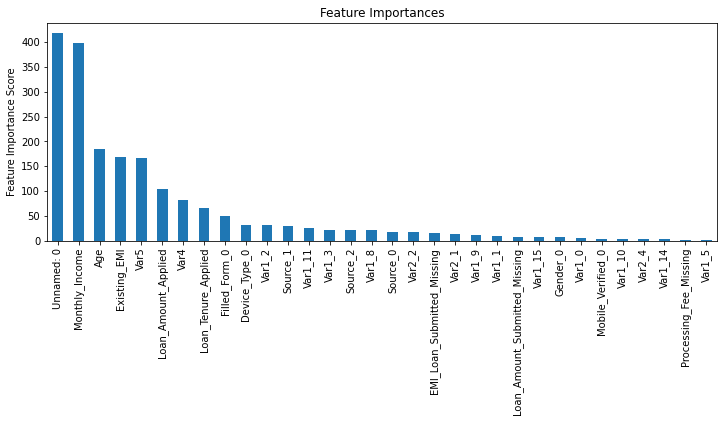

In [7]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=150,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, X_train, X_test, predictors)

Перебираем max_depth и min_child_weight по сетке.

In [8]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=150,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train[predictors],X_train[target])

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, t

In [9]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.8261434629208845)

Уточняем предсказание

In [10]:
param_test2 = {
    'max_depth':[2,3,4],
    'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, 
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(X_train[predictors],X_train[target])

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/data/home/irsafilo/course/shad/venv/lib/python3

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, t

In [11]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 4, 'min_child_weight': 4}, 0.8284968932982999)

Зафиксируем найденный max_depth и подберем min_child_weight

In [12]:
param_test2b = {
    'min_child_weight':[5,6,7]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=4,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2b, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2b.fit(X_train[predictors],X_train[target])

/data/home/irsafilo/course/shad/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, tree

In [13]:
gsearch2b.best_params_, gsearch2b.best_score_

({'min_child_weight': 5}, 0.8259821843797572)

Мы подобрали max_depth и min_child_weight - дальше будем использовать подобранные значения параметров. Подберите по сетке параметр gamma на отрезке от 0 до 1.

In [14]:
param_test3 = {
    'gamma':#your code here
}
gsearch3b = #your code here
gsearch3b.fit(X_train[predictors],X_train[target])

SyntaxError: invalid syntax (4108316046.py, line 3)

In [ ]:
gsearch3b.best_params_, gsearch3b.best_score_

Установите в качестве параметров алгоритма подобранные max_depth, min_child_weight и gamma и посмотрите как изменилось качество.

In [ ]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=150,
        max_depth=...,
        min_child_weight=...,
        gamma = ...,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb2, X_train, X_test, predictors)

Подберите по сетке параметры subsample и colsample_bytree. Используйте значения этих параметров: [0.6,0.7,0.8,0.9,1.]

In [ ]:
#Your code here

Уточните значения subsample и colsample_bytree. Например, если оптимальный subsample на предыдущем шаге равен 0.6, то теперь перебирайте subsample в диапазоне [0.55,0.6,0.65,0.7]. Аналогично с colsample_bytree.

In [ ]:
#Your code here

Подберите параметр регуляризации reg_alpha. Попробуйте [1e-5, 1e-2, 0.1, 1, 100]

In [ ]:
#Your code here

Уточните параметр reg_alpha, исходя из найденного оптимума.

In [ ]:
#Your code here

Запустите обучение и предсказание на найденных параметрах и посмотрите на качество.

In [ ]:
xgb3 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=150,
        max_depth=...,
        min_child_weight=...,
        gamma=...,
        subsample=...,
        colsample_bytree=...,
        reg_alpha=...,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb3, X_train, X_test, predictors)

Уменьшите learning_rate до 0.01 и пропорционально увеличьте число деревьев. Все подобранные параметры остаются такими же. Обучите модель и сделайте предсказание. Посмотрите на качество.

In [ ]:
#Your code here
xgb3 = XGBClassifier(
        learning_rate=0.01,
        n_estimators=1500,
        max_depth=...,
        min_child_weight=...,
        gamma=...,
        subsample=...,
        colsample_bytree=...,
        reg_alpha=...,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb3, X_train, X_test, predictors)